#  Cleaning and Inventory

In this pack there are 326 stroke patients which have a total of 8454 images associated. Using the folder of images that we receive from the hospital X, we create the part1_inventory_test.csv which contains all the metadata of the received images. The initial file format follows the DICOM standard, which you can check here: https://dicom.innolitics.com/ciods. In the part1_inventory_test.csv file each row represents an image in the package, and each column a dicom standard metadata field.

In order to apply our deep learning algorithms to this dataset, we first have to select the correct NCCT (Non-Contrast CT) image (out of the many images that we have) for each patient. Selecting the right NCCT is critical to achieve a good performance in the clinical study or to train a good algorithm. 

The challenge consists on a small simplified version of this task: 

● Select the correct NCCT image for each of the 326 patients. 

● The correct NCCT must meet the following characteristics: non-contrast image, CT modality, axial orientation, slice thickness between 2.5 and 5 mm’s, first (in time) NCCT acquired. 

Some hints on the data: 

● A patient (PatientID) may have several studies (StudyInstanceUID - group of images), and within the study there can be many images (SeriesInstanceUID - single image).

● Each row of the part1_inventory_test.csv is the metadata of the image (unique SeriesInstanceUID). 

● In this inventory you may find different kinds of image modalities: CT (NCCT or CTA), DWI, MRI, CTP, etc. Note that the DICOM modality column is not enough to complete the exercise, as NCCT and CTA are both CTs.

● The most difficult ambiguity to discern using only image metadata is whether the image is an NCCT or a CTA, you have an image above of how they look (A CTA is a CT acquisition with an injection of contrast in the patient's arteries).

● Other important data fields: Modality, ImageOrientationPatient, SeriesDescription, StudyDescription, ImageType, SliceThickness, etc. 

Since we have already solved it, we will provide you with an example of 25 selected NCCT images (example_solution.csv) with some relevant fields, in order to show you an example of how the final result should look like. 

The correct NCCT must meet the following characteristics:

    1) non-contrast image -> can't be defined straight forward
    
    2) CT modality -> can be filtered from 'Modality' == 'CT'
    
    3) axial orientation -> can be filtered from 'ImageOrientationPatient' == ['1', '0', '0', '0', '1', '0']
    
    4) slice thickness between 2.5 and 5 mm’s -> can be filtered from 2.5 <= 'SliceThickness' <= 5
    
    5) first (in time) NCCT acquired. -> 
    
    Other columns used in solution_df or in the instructions to achieve 1) Non-contrast Image:
    
    6) 'SeriesDescription'
    
    7) 'StudyDescription'
   
    8) 'ImageType'
    

In [1]:
import pandas as pd

In [2]:
!pwd

/home/carlosgil/code/Charlie5545/data-specialist-methinks-challenge/data-specialist-methinks-challenge


In [3]:
df = pd.read_csv('data/part1_inventory_test.csv',low_memory = False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8454 entries, 0 to 8453
Columns: 206 entries, PatientID to RouteOfAdmissions
dtypes: float64(113), int64(13), object(80)
memory usage: 13.3+ MB


In [5]:
solution_df = pd.read_csv('data/example_solution.csv',low_memory = False)

In [6]:
solution_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PatientID          25 non-null     object 
 1   StudyInstanceUID   25 non-null     object 
 2   SeriesInstanceUID  25 non-null     object 
 3   StudyDescription   25 non-null     object 
 4   SeriesDescription  25 non-null     object 
 5   PixelSpacing       25 non-null     object 
 6   SliceThickness     25 non-null     float64
 7   ConvolutionKernel  25 non-null     object 
dtypes: float64(1), object(7)
memory usage: 1.7+ KB


In [7]:
filtered_columns = list(solution_df.columns) + ['ImageOrientationPatient','Modality']
filtered_columns

['PatientID',
 'StudyInstanceUID',
 'SeriesInstanceUID',
 'StudyDescription',
 'SeriesDescription',
 'PixelSpacing',
 'SliceThickness',
 'ConvolutionKernel',
 'ImageOrientationPatient',
 'Modality']

In [8]:
df = df[filtered_columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8454 entries, 0 to 8453
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                8454 non-null   object 
 1   StudyInstanceUID         8454 non-null   object 
 2   SeriesInstanceUID        8454 non-null   object 
 3   StudyDescription         8454 non-null   object 
 4   SeriesDescription        8453 non-null   object 
 5   PixelSpacing             8365 non-null   object 
 6   SliceThickness           7410 non-null   float64
 7   ConvolutionKernel        5033 non-null   object 
 8   ImageOrientationPatient  7709 non-null   object 
 9   Modality                 8454 non-null   object 
dtypes: float64(1), object(9)
memory usage: 660.6+ KB


### Removing columns with < 30% NaN's 

In [10]:
threshold = int(df.shape[0] * 0.3)
df = df.dropna(axis=1, thresh=threshold)

## Modality == 'CT'

In [11]:
df.Modality.unique()

array(['CT', 'MR', 'OT', 'XA'], dtype=object)

In [12]:
modality_df = df[df.Modality == 'CT']

In [13]:
modality_df.PatientID.unique().size

326

## Axial Orientation == ['1', '0', '0', '0', '1', '0']

In [14]:
df[df.ImageOrientationPatient == '1\\0\\0\\0\\1\\0'].PatientID.unique().size

306

Defining 0.15 tolerance for Axial Orientation

In [87]:
def tolerance(value, target, tolerance=0.15):
    if pd.isna(value):  # Check for NaN
        return False
    
    # Convert value to string and split
    components = list(map(float, str(value).split('\\')))
    target_components = list(map(float, target.split('\\')))
    
    return all(abs(comp - tgt) <= tolerance for comp, tgt in zip(components, target_components))

# Target string to compare against
target_value = '1\\0\\0\\0\\1\\0'

# Filtering the DataFrame based on closeness to the target value
axial_df = modality_df[modality_df.ImageOrientationPatient.apply(lambda x: tolerance(x, target_value))]

In [88]:
axial_df.PatientID.unique().size

324

In [89]:
axial_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4433 entries, 1 to 8447
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                4433 non-null   object 
 1   StudyInstanceUID         4433 non-null   object 
 2   SeriesInstanceUID        4433 non-null   object 
 3   StudyDescription         4433 non-null   object 
 4   SeriesDescription        4433 non-null   object 
 5   PixelSpacing             4433 non-null   object 
 6   SliceThickness           4403 non-null   float64
 7   ConvolutionKernel        3273 non-null   object 
 8   ImageOrientationPatient  4433 non-null   object 
 9   Modality                 4433 non-null   object 
dtypes: float64(1), object(9)
memory usage: 381.0+ KB


## Slice Thickness

In [18]:
thickness_df = axial_df[(axial_df.SliceThickness >= 2.5) & (axial_df.SliceThickness <= 5)]

In [19]:
thickness_df.PatientID.unique().size

305

In [20]:
thickness_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 1 to 8393
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                867 non-null    object 
 1   StudyInstanceUID         867 non-null    object 
 2   SeriesInstanceUID        867 non-null    object 
 3   StudyDescription         867 non-null    object 
 4   SeriesDescription        867 non-null    object 
 5   PixelSpacing             867 non-null    object 
 6   SliceThickness           867 non-null    float64
 7   ConvolutionKernel        688 non-null    object 
 8   ImageOrientationPatient  867 non-null    object 
 9   Modality                 867 non-null    object 
dtypes: float64(1), object(9)
memory usage: 74.5+ KB


## Series Description

Words to take into account and further study: Stroke, Neuro,..?

In [21]:
df.SeriesDescription.unique().size

772

In [22]:
solution_df.SeriesDescription.unique()

array(['Head__5_0__J37s__1', 'Head__3_0__J30s', 'Head_5_0',
       'brain_Head_3_0', 'noncontrast_Head_3_0', 'brain_ST_Head_3_0',
       'Head_SPIRAL_Spiral', 'Head__3_0__J37s__1', 'AXIAL_HEAD',
       'noncontrast_Head_3_000', 'Head_3_0__Axial____FC64',
       'HEAD_3_75mm_Soft', 'Head_WO__3_0__J30f__SOFT'], dtype=object)

In [23]:
# Filtering based on 'Head', 'HEAD', or 'Brain' in 'SeriesDescription'
seriesdesc_df = thickness_df[
    thickness_df.SeriesDescription.str.contains('head|brain', case=False, na=False)
]

In [24]:
seriesdesc_df.PatientID.unique().size

291

In [25]:
seriesdesc_df.SeriesDescription.unique().size

58

In [26]:
seriesdesc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 1 to 8393
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                659 non-null    object 
 1   StudyInstanceUID         659 non-null    object 
 2   SeriesInstanceUID        659 non-null    object 
 3   StudyDescription         659 non-null    object 
 4   SeriesDescription        659 non-null    object 
 5   PixelSpacing             659 non-null    object 
 6   SliceThickness           659 non-null    float64
 7   ConvolutionKernel        651 non-null    object 
 8   ImageOrientationPatient  659 non-null    object 
 9   Modality                 659 non-null    object 
dtypes: float64(1), object(9)
memory usage: 56.6+ KB


## Study Description

Not sure about:
    
CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T) -> included in solution

CT ANGIO HEAD & NECK W/WO (70496, 70498) -> not included in solution

CT ANGIO HEAD W/WO CONTRAST (70496) ->not included in solution

In [27]:
df.StudyDescription.unique()

array(['CT BRAIN WO CONTRAST (70450)',
       'CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'MRI BRAIN W/WO CONTRAST (70553)',
       'CT ANGIO HEAD & NECK W/WO (70496, 70498)',
       'CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'EXTERNAL CT-STORE & INTERPRET',
       'CT ANGIO HEAD W/WO CONTRAST (70496)', 'EXTERNAL CT - STORE ONLY',
       'MRI BRAIN WO CONTRAST (70551)', 'EXTERNAL CT - STORE ONLY - RAD',
       'IR NEURO RADIOLOGY PROCEDURE',
       'EXTERNAL CT BRAIN - STORE ONLY - RAD',
       'EXTERNAL CTA HEAD - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN - STORE ONLY', 'EXTERNAL CTA HEAD - STORE ONLY',
       'EXTERNAL CT BRAIN INTERPRET', 'EXTERNAL CTA HEAD INTERPRET'],
      dtype=object)

In [28]:
solution_df.StudyDescription.unique()

array(['CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'EXTERNAL CT - STORE ONLY', 'EXTERNAL CT - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN - STORE ONLY', 'CT BRAIN WO CONTRAST (70450)',
       'EXTERNAL CT BRAIN INTERPRET'], dtype=object)

In [29]:
# Filter StudyDescription to exclude CTA or Angio
studydesc_df = seriesdesc_df[
    (~seriesdesc_df.StudyDescription.str.contains('angio|CTA HEAD', case=False, na=False))
]

In [30]:
studydesc_df.StudyDescription.unique()

array(['CT BRAIN WO CONTRAST (70450)',
       'CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'EXTERNAL CT-STORE & INTERPRET',
       'CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'EXTERNAL CT - STORE ONLY - RAD', 'EXTERNAL CT - STORE ONLY',
       'EXTERNAL CT BRAIN - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN INTERPRET', 'EXTERNAL CT BRAIN - STORE ONLY'],
      dtype=object)

In [31]:
studydesc_df.PatientID.unique().size

287

In [32]:
studydesc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626 entries, 1 to 8393
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                626 non-null    object 
 1   StudyInstanceUID         626 non-null    object 
 2   SeriesInstanceUID        626 non-null    object 
 3   StudyDescription         626 non-null    object 
 4   SeriesDescription        626 non-null    object 
 5   PixelSpacing             626 non-null    object 
 6   SliceThickness           626 non-null    float64
 7   ConvolutionKernel        618 non-null    object 
 8   ImageOrientationPatient  626 non-null    object 
 9   Modality                 626 non-null    object 
dtypes: float64(1), object(9)
memory usage: 53.8+ KB


## Pixel Spacing

Study if it's needed to determine a threshold for this value

In [33]:
df.PixelSpacing.unique().size

863

In [34]:
solution_df.PixelSpacing.unique()

array(['[0.46875, 0.46875]', '[0.47265625, 0.47265625]', '[0.417, 0.417]',
       '[0.456, 0.456]', '[0.517, 0.517]', '[0.430, 0.430]',
       '[0.455078125, 0.455078125]', '[0.39086294416244, 0.390625]',
       '[0.390625, 0.390625]', '[0.527000, 0.527000]', '[0.429, 0.429]',
       '[0.451171875, 0.451171875]', '[0.454, 0.454]',
       '[0.488281, 0.488281]', '[0.459, 0.459]', '[0.4296875, 0.4296875]',
       '[0.38850174216028, 0.388671875]'], dtype=object)

In [35]:
studydesc_df.PixelSpacing.unique()

array(['0.46875\\0.46875', '0.36156351791531\\0.361328125',
       '0.25390625\\0.25390625', '0.48046875\\0.48046875',
       '0.392578125\\0.392578125', '0.392578125\\0.39279869067103',
       '0.396484375\\0.396484375', '0.37890625\\0.37890625',
       '0.427734375\\0.427734375', '0.41030534351145\\0.41015625',
       '0.33177570093458\\0.33203125', '0.515625\\0.515625',
       '0.488281\\0.488281', '1.033203125\\1.033203125',
       '1.029296875\\1.029296875', '0.51953125\\0.51953125',
       '1.02734375\\1.02734375', '0.9765625\\0.9765625',
       '1.03125\\1.03125', '0.978515625\\0.978515625',
       '1.03515625\\1.03515625', '0.98046875\\0.98046875',
       '0.541015625\\0.541015625', '0.533203125\\0.533203125',
       '0.468\\0.468', '0.98828125\\0.98828125', '0.430\\0.430',
       '0.47265625\\0.47265625', '0.456\\0.456', '0.527000\\0.527000',
       '0.435546875\\0.435546875', '0.4296875\\0.4296875'], dtype=object)

In [36]:
def filter_pixel_spacing(value):
    # Split the PixelSpacing string
    values = value.split('\\')
    
    # Convert the split values into floats
    val1 = float(values[0])
    val2 = float(values[1])
    
    # Check if both values are less than or equal to 0.53
    return val1 <= 0.53 and val2 <= 0.53

In [37]:
pixelsp_df = studydesc_df[studydesc_df.PixelSpacing.apply(filter_pixel_spacing)]

In [38]:
pixelsp_df.PatientID.unique().size

287

In [39]:
pixelsp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 1 to 8393
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                609 non-null    object 
 1   StudyInstanceUID         609 non-null    object 
 2   SeriesInstanceUID        609 non-null    object 
 3   StudyDescription         609 non-null    object 
 4   SeriesDescription        609 non-null    object 
 5   PixelSpacing             609 non-null    object 
 6   SliceThickness           609 non-null    float64
 7   ConvolutionKernel        601 non-null    object 
 8   ImageOrientationPatient  609 non-null    object 
 9   Modality                 609 non-null    object 
dtypes: float64(1), object(9)
memory usage: 52.3+ KB


## Convolution Kernel

Decided not to use it for this prior study

In [41]:
df.ConvolutionKernel.unique() 

array(['T20f', 'J37s\\1', 'J70h\\1', 'Tr20f', 'Hc40s\\2', 'Br64s\\2', nan,
       'T80f', 'H20f', 'Hr36d', 'H41s', 'H70h', 'Hr38s\\2', 'Br64s\\3',
       'J37f\\1', 'Q40f\\1', 'Hr68h\\2', 'J30f\\2', 'T20s', 'H37s',
       'H40s', 'STANDARD', 'BONE', 'H41f', 'UC', 'H31f', 'H60f',
       'I30f\\3', 'I40f\\3', 'B30f', 'H31s', 'FC03', 'FL04', 'FL03',
       'FC43', 'J37s\\3', 'J70h\\3', 'Hc40s', 'I40s\\3', 'B60s', 'B70s',
       'Hc40s\\3', 'Bv36d\\3', 'Bv36d', 'LUNG', 'J37f\\3', 'H40f', 'H10s',
       'I80s\\1', 'J40s\\2', 'I30f\\2', 'J30f\\3', 'H60s', '01', '54',
       '42', '12', 'SOFT', 'FC21', 'FC30', 'J30s\\1', 'FC26', 'I40f\\2',
       'B20f', 'FC68', 'FC35', 'BONEPLUS', 'FC41', 'H50s', 'FC64',
       'Qr36d\\3', 'Qr40s\\2'], dtype=object)

In [42]:
solution_df.ConvolutionKernel.unique()

array(["['J37s', '1']", "['J30s', '1']", 'FC26', 'FC68', 'FC21', 'H31f',
       'FC64', 'STANDARD', "['J30f', '3']"], dtype=object)

In [43]:
pixelsp_df.ConvolutionKernel.unique()

array(['J37s\\1', 'J70h\\1', 'Hc40s\\2', 'Br64s\\2', 'H41s', 'H70h',
       'Hr38s\\2', nan, 'J37f\\1', 'Q40f\\1', 'Hr68h\\2', 'H37s', 'H40s',
       'STANDARD', 'BONE', 'H41f', 'Hc40s\\3', 'J40s\\2', 'J70h\\3', '54',
       'FC21', 'J30s\\1', 'FC68', 'FC30', 'H31s', 'J30f\\3', 'H60f'],
      dtype=object)

## Further analysis, SeriesInstanceUID that are duplicated?

This was determined not to be considered 

In [44]:
filtered_df = df[~df.duplicated(subset=['SeriesInstanceUID'], keep='first')]

In [45]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8299 entries, 0 to 8453
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                8299 non-null   object 
 1   StudyInstanceUID         8299 non-null   object 
 2   SeriesInstanceUID        8299 non-null   object 
 3   StudyDescription         8299 non-null   object 
 4   SeriesDescription        8298 non-null   object 
 5   PixelSpacing             8213 non-null   object 
 6   SliceThickness           7267 non-null   float64
 7   ConvolutionKernel        4943 non-null   object 
 8   ImageOrientationPatient  7565 non-null   object 
 9   Modality                 8299 non-null   object 
dtypes: float64(1), object(9)
memory usage: 713.2+ KB


In [46]:
filtered_df.PatientID.unique().size

323

In [47]:
filtered_df.StudyInstanceUID.unique().size

502

In [49]:
# Get duplicate SeriesInstanceUIDs
duplicate_series = filtered_df[filtered_df.SeriesInstanceUID.duplicated(keep=False)]

# Extract the unique duplicate SeriesInstanceUID values
unique_duplicate_series = duplicate_series.SeriesInstanceUID.unique()

## Compilation of Previous code - End of First Task

In [50]:
import pandas as pd

# Load the dataset with optimized memory usage
df = pd.read_csv('data/part1_inventory_test.csv', low_memory=False)

# Define the target columns to be used in the analysis
target_columns = ['PatientID',
                  'StudyInstanceUID',
                  'SeriesInstanceUID',
                  'StudyDescription',
                  'SeriesDescription',
                  'PixelSpacing',
                  'SliceThickness',
                  'ConvolutionKernel',
                  'ImageOrientationPatient',
                  'Modality']

# Filter DataFrame to include only the target columns and remove columns with more than 30% missing values
threshold = int(df.shape[0] * 0.3)
df = df[target_columns].dropna(axis=1, thresh=threshold)

# Filter for rows where the modality is 'CT' (Computed Tomography)
df = df[df.Modality == 'CT']

# Function to check if the ImageOrientationPatient values are within a tolerance of the target
def tolerance(value, target, tolerance=0.15):
    """Check if the orientation components of `value` are within the specified tolerance of `target`."""
    if pd.isna(value):  # Handle missing values
        return False
    
    # Convert value and target into lists of float components
    components = list(map(float, str(value).split('\\')))
    target_components = list(map(float, target.split('\\')))
    
    # Check if all components are within the tolerance range
    return all(abs(comp - tgt) <= tolerance for comp, tgt in zip(components, target_components))

# Define the target axial orientation to compare against
target_orientation = '1\\0\\0\\0\\1\\0'

# Filter based on closeness to the target axial orientation
df = df[df.ImageOrientationPatient.apply(lambda x: tolerance(x, target_orientation))]

# Filter rows where Slice Thickness is between 2.5 and 5 mm
df = df[(df.SliceThickness >= 2.5) & (df.SliceThickness <= 5)]

# Filter SeriesDescription to include only rows with 'head' or 'brain' (case insensitive)
df = df[df.SeriesDescription.str.contains('head|brain', case=False, na=False)]

# Filter StudyDescription to exclude rows with 'CTA HEAD' or 'Angio' (case insensitive)
df = df[~df.StudyDescription.str.contains('angio|CTA HEAD', case=False, na=False)]

# Function to filter PixelSpacing values where both components are less than or equal to 0.53 mm
def filter_pixel_spacing(value):
    """Return True if both components of PixelSpacing are <= 0.53 mm, otherwise False."""
    try:
        # Split the PixelSpacing into two values and convert them to floats
        val1, val2 = map(float, value.split('\\'))
    except (ValueError, AttributeError):
        return False  # Handle any potential issues with missing or malformed data
    
    # Check if both values are less than or equal to the threshold (0.53 mm)
    return val1 <= 0.53 and val2 <= 0.53

# Apply PixelSpacing filter to keep rows with PixelSpacing <= 0.53 mm for both dimensions
final_df = df[df.PixelSpacing.apply(filter_pixel_spacing)]

# Display the resulting filtered DataFrame
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 1 to 8393
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                609 non-null    object 
 1   StudyInstanceUID         609 non-null    object 
 2   SeriesInstanceUID        609 non-null    object 
 3   StudyDescription         609 non-null    object 
 4   SeriesDescription        609 non-null    object 
 5   PixelSpacing             609 non-null    object 
 6   SliceThickness           609 non-null    float64
 7   ConvolutionKernel        601 non-null    object 
 8   ImageOrientationPatient  609 non-null    object 
 9   Modality                 609 non-null    object 
dtypes: float64(1), object(9)
memory usage: 52.3+ KB


## ETL Integration

In [51]:
import pandas as pd
import logging

# Set up logging for the ETL process
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def extract_data(file_path):
    """Extract data from CSV file."""
    try:
        logging.info("Extracting data from CSV file.")
        df = pd.read_csv(file_path, low_memory=False)
        logging.info(f"Data extraction complete. Rows: {df.shape[0]}, Columns: {df.shape[1]}")
        return df
    except Exception as e:
        logging.error(f"Error during data extraction: {e}")
        raise

def transform_data(df):
    """Transform the data by filtering and processing."""
    logging.info("Starting data transformation.")

    # Define the target columns to be used in the analysis
    target_columns = ['PatientID',
                      'StudyInstanceUID',
                      'SeriesInstanceUID',
                      'StudyDescription',
                      'SeriesDescription',
                      'PixelSpacing',
                      'SliceThickness',
                      'ConvolutionKernel',
                      'ImageOrientationPatient',
                      'Modality']

    # Filter DataFrame to include only the target columns and remove columns with more than 30% missing values
    threshold = int(df.shape[0] * 0.3)
    df = df[target_columns].dropna(axis=1, thresh=threshold)

    # Filter for rows where the modality is 'CT'
    df = df[df.Modality == 'CT']

    # Function to check if the ImageOrientationPatient values are within a tolerance of the target
    def tolerance(value, target, tolerance=0.15):
        if pd.isna(value):
            return False
        components = list(map(float, str(value).split('\\')))
        target_components = list(map(float, target.split('\\')))
        return all(abs(comp - tgt) <= tolerance for comp, tgt in zip(components, target_components))

    # Target orientation to compare against
    target_orientation = '1\\0\\0\\0\\1\\0'
    df = df[df.ImageOrientationPatient.apply(lambda x: tolerance(x, target_orientation))]

    # Filter rows where Slice Thickness is between 2.5 and 5 mm
    df = df[(df.SliceThickness >= 2.5) & (df.SliceThickness <= 5)]

    # Filter SeriesDescription to include only rows with 'head' or 'brain'
    df = df[df.SeriesDescription.str.contains('head|brain', case=False, na=False)]

    # Filter StudyDescription to exclude rows with 'CTA HEAD' or 'Angio'
    df = df[~df.StudyDescription.str.contains('angio|CTA HEAD', case=False, na=False)]

    # Function to filter PixelSpacing values
    def filter_pixel_spacing(value):
        try:
            val1, val2 = map(float, value.split('\\'))
        except (ValueError, AttributeError):
            return False
        return val1 <= 0.53 and val2 <= 0.53

    # Apply PixelSpacing filter
    df = df[df.PixelSpacing.apply(filter_pixel_spacing)]

    logging.info(f"Data transformation complete. Rows after transformation: {df.shape[0]}")
    return df

def load_data(df, output_file):
    """Load transformed data to a CSV file."""
    try:
        logging.info(f"Loading data to {output_file}.")
        df.to_csv(output_file, index=False)
        logging.info("Data loading complete.")
    except Exception as e:
        logging.error(f"Error during data loading: {e}")
        raise

def main():
    """Main ETL function to orchestrate the process."""
    input_file = 'data/part1_inventory_test.csv'
    output_file = 'data/transformed_inventory_data.csv'
    
    # Extract, Transform, Load process
    try:
        df = extract_data(input_file)
        transformed_df = transform_data(df)
        load_data(transformed_df, output_file)
    except Exception as e:
        logging.error(f"ETL process failed: {e}")

if __name__ == "__main__":
    main()


2024-10-09 11:43:47,670 - INFO - Extracting data from CSV file.
2024-10-09 11:43:47,855 - INFO - Data extraction complete. Rows: 8454, Columns: 206
2024-10-09 11:43:47,856 - INFO - Starting data transformation.
2024-10-09 11:43:47,907 - INFO - Data transformation complete. Rows after transformation: 609
2024-10-09 11:43:47,908 - INFO - Loading data to data/transformed_inventory_data.csv.
2024-10-09 11:43:47,925 - INFO - Data loading complete.


## Comments and further improvements:

In [61]:
original_df = pd.read_csv('data/part1_inventory_test.csv',low_memory = False)

In [62]:
df2 = pd.read_csv(file_path, low_memory=False)

In [63]:
df2[~df2.Patient_name.isin(pixelsp_df.PatientID)]

,Patient_name,Model_1,Model_2,Ground_truth
17,K80,0.524756,0.802197,0
32,K67,0.065052,0.330898,1
42,G136,0.034389,0.760785,1
44,K50,0.258780,0.770967,0
45,G116,0.662522,0.493796,1


Patients not collected with my ETL:
    
    K80: ImageOrientationPatient tolerance was 0.1, and now increased to 0.15 to capture 5 more patients.
        
    K67: Also because of ImageOrientationPatient
        
    G136: ImageOrientationPatient tolerance is out (has some values over 0.2 mm)
    
    K50: Also because of ImageOrientationPatient
        
    G116: Not filtered due to different reasons: some ImageOrientationPatient are over the tolerance, some pixel spacings are greater than 0.5, SeriesDescription has 2_0 which is not included in the query 

# Analysis

## Performance Metrics

You will have to first compute some basic metrics on these data:

1. Compute AUROC (Area Under the ROC Curve) of Model_1 and Model_2 and select
the one with a higher AUROC.


2. Compute sensitivity and specificity with these thresholds: [0.3, 0.5, 0.7, 0.9].
Select the threshold that results in a specificity of around 80%.


3. Select the False Negative patients obtained with the selected threshold in the
previous step.

In [182]:
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix

In [183]:
file_path = 'data/part2_inferences.csv'

In [184]:
df2 = pd.read_csv(file_path, low_memory=False)

In [185]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Patient_name  50 non-null     object 
 1   Model_1       50 non-null     float64
 2   Model_2       50 non-null     float64
 3   Ground_truth  50 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.7+ KB


In [186]:
df2.head()

,Patient_name,Model_1,Model_2,Ground_truth
0,X77,0.374540,0.969585,0
1,X3,0.950714,0.775133,1
2,X99,0.731994,0.939499,0
3,K18,0.598658,0.894827,0
4,X13,0.156019,0.597900,1


Code asuming the statement is Calculating False Negatives

In [176]:
# 1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC
auroc_model_1 = roc_auc_score(df2['Ground_truth'], df2['Model_1'])
auroc_model_2 = roc_auc_score(df2['Ground_truth'], df2['Model_2'])

if auroc_model_1 > auroc_model_2:
    best_model = 'Model_1'
    predictions = df2['Model_1']
else:
    best_model = 'Model_2'
    predictions = df2['Model_2']

print('1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC', '\n')
    
print(f"Best model: {best_model}, \nAUROC Model_1: {auroc_model_1} \nAUROC Model_2: {auroc_model_2}",'\n')

# 2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9]
thresholds = [0.3, 0.5, 0.7, 0.9]
best_threshold = None

def calculate_sensitivity_specificity(y_true, y_pred, threshold):
    y_pred_thresh = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity, specificity

print("2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9]",'\n')

for threshold in thresholds:
    sensitivity, specificity = calculate_sensitivity_specificity(df2['Ground_truth'], predictions, threshold)
    print(f"Threshold: {threshold}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")
    if 0.75 <= specificity <= 0.85:  # Selecting the threshold with specificity around 80%
        best_threshold = threshold

print(f"Selected threshold: {best_threshold}",'\n')

# 3. Select False Negative patients with the selected threshold

print('3. Select False Negative patients with the selected threshold','\n')

if best_threshold is not None:
    y_pred_thresh = (predictions >= best_threshold).astype(int)
    df2['False_Negative'] = ((df2['Ground_truth'] == 1) & (y_pred_thresh == 0))
    false_negative_patients = df2[df2['False_Negative']]['Patient_name']
    print("False Negative patients:", false_negative_patients.tolist())
else:
    print("No threshold resulted in a specificity around 80%.")

1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC 

Best model: Model_1, 
AUROC Model_1: 0.5096153846153846 
AUROC Model_2: 0.34134615384615385 

2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9] 

Threshold: 0.3, Sensitivity: 0.67, Specificity: 0.42
Threshold: 0.5, Sensitivity: 0.42, Specificity: 0.54
Threshold: 0.7, Sensitivity: 0.25, Specificity: 0.81
Threshold: 0.9, Sensitivity: 0.12, Specificity: 0.92
Selected threshold: 0.7 

3. Select False Negative patients with the selected threshold 

False Negative patients: ['X13', 'D7', 'D20', 'X34', 'K32', 'K51', 'G12', 'E76', 'K7', 'X17', 'B27', 'K67', 'E15', 'K3', 'X69', 'G121', 'G136', 'G116']


Code asuming the statement is calculating False Positives

In [187]:
# 1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC
auroc_model_1 = roc_auc_score(df2['Ground_truth'], df2['Model_1'])
auroc_model_2 = roc_auc_score(df2['Ground_truth'], df2['Model_2'])

if auroc_model_1 > auroc_model_2:
    best_model = 'Model_1'
    predictions = df2['Model_1']
else:
    best_model = 'Model_2'
    predictions = df2['Model_2']

print('1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC', '\n')
    
print(f"Best model: {best_model}, \nAUROC Model_1: {auroc_model_1} \nAUROC Model_2: {auroc_model_2}",'\n')

# 2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9]
thresholds = [0.3, 0.5, 0.7, 0.9]
best_threshold = None

def calculate_sensitivity_specificity(y_true, y_pred, threshold):
    y_pred_thresh = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity, specificity

print("2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9]",'\n')

for threshold in thresholds:
    sensitivity, specificity = calculate_sensitivity_specificity(df2['Ground_truth'], predictions, threshold)
    print(f"Threshold: {threshold}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")
    if 0.75 <= specificity <= 0.85:  # Selecting the threshold with specificity around 80%
        best_threshold = threshold

print(f"Selected threshold: {best_threshold}",'\n')

# 3. Select False Positive patients with the selected threshold

print('3. Select False Positive patients with the selected threshold','\n')

if best_threshold is not None:
    y_pred_thresh = (predictions >= best_threshold).astype(int)
    df2['False_Positive'] = ((df2['Ground_truth'] == 0) & (y_pred_thresh == 1))
    false_negative_patients = df2[df2['False_Positive']]['Patient_name']
    print("False Positive patients:", false_positive_patients.tolist())
else:
    print("No threshold resulted in a specificity around 80%.")

1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC 

Best model: Model_1, 
AUROC Model_1: 0.5096153846153846 
AUROC Model_2: 0.34134615384615385 

2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9] 

Threshold: 0.3, Sensitivity: 0.67, Specificity: 0.42
Threshold: 0.5, Sensitivity: 0.42, Specificity: 0.54
Threshold: 0.7, Sensitivity: 0.25, Specificity: 0.81
Threshold: 0.9, Sensitivity: 0.12, Specificity: 0.92
Selected threshold: 0.7 

3. Select False Positive patients with the selected threshold 

False Positive patients: ['X99', 'G30', 'K91', 'E139', 'G66']


## Image Analysis 

In [193]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [195]:
!pwd

/home/carlosgil/code/Charlie5545/data-specialist-methinks-challenge/data-specialist-methinks-challenge


In [201]:
# Define the paths to the images and masks
img_dir = 'data/imgs'  # Path to your imgs folder
mask_dir = 'data/masks'  # Path to your masks folder

# Function to load gzipped NIfTI files
def load_gzipped_nifti_files(img_dir, mask_dir):
    images = []
    masks = []
    patient_names = []
    for img_file in sorted(os.listdir(img_dir)):
        if img_file.endswith('.nii.gz'):  # Check for gzipped NIfTI images
            img_path = os.path.join(img_dir, img_file)
            
            # Create the corresponding mask filename
            mask_file_name = img_file.replace('.nii.gz', '_mask.nii.gz')  # Mask files are gzipped too
            mask_path = os.path.join(mask_dir, mask_file_name)
            
            # Print paths for debugging
            print(f"Loading image from: {img_path}")
            print(f"Loading mask from: {mask_path}")

            # Check if mask file exists
            if not os.path.exists(mask_path):
                print(f"Warning: Mask file {mask_path} does not exist. Skipping this file.")
                continue
            
            image = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
            images.append(image)
            masks.append(mask)
            patient_names.append(img_file.split('.')[0])  # Extract patient name without the extension
    return images, masks, patient_names

# Load images and masks
images, masks, patient_names = load_gzipped_nifti_files(img_dir, mask_dir)

Loading image from: data/imgs/E139.nii.gz
Loading mask from: data/masks/E139_mask.nii.gz
Loading image from: data/imgs/G30.nii.gz
Loading mask from: data/masks/G30_mask.nii.gz
Loading image from: data/imgs/G66.nii.gz
Loading mask from: data/masks/G66_mask.nii.gz
Loading image from: data/imgs/K91.nii.gz
Loading mask from: data/masks/K91_mask.nii.gz
Loading image from: data/imgs/X99.nii.gz
Loading mask from: data/masks/X99_mask.nii.gz


### Compute the image histogram. You should see that two patients have something weird in the histogram, identify them.

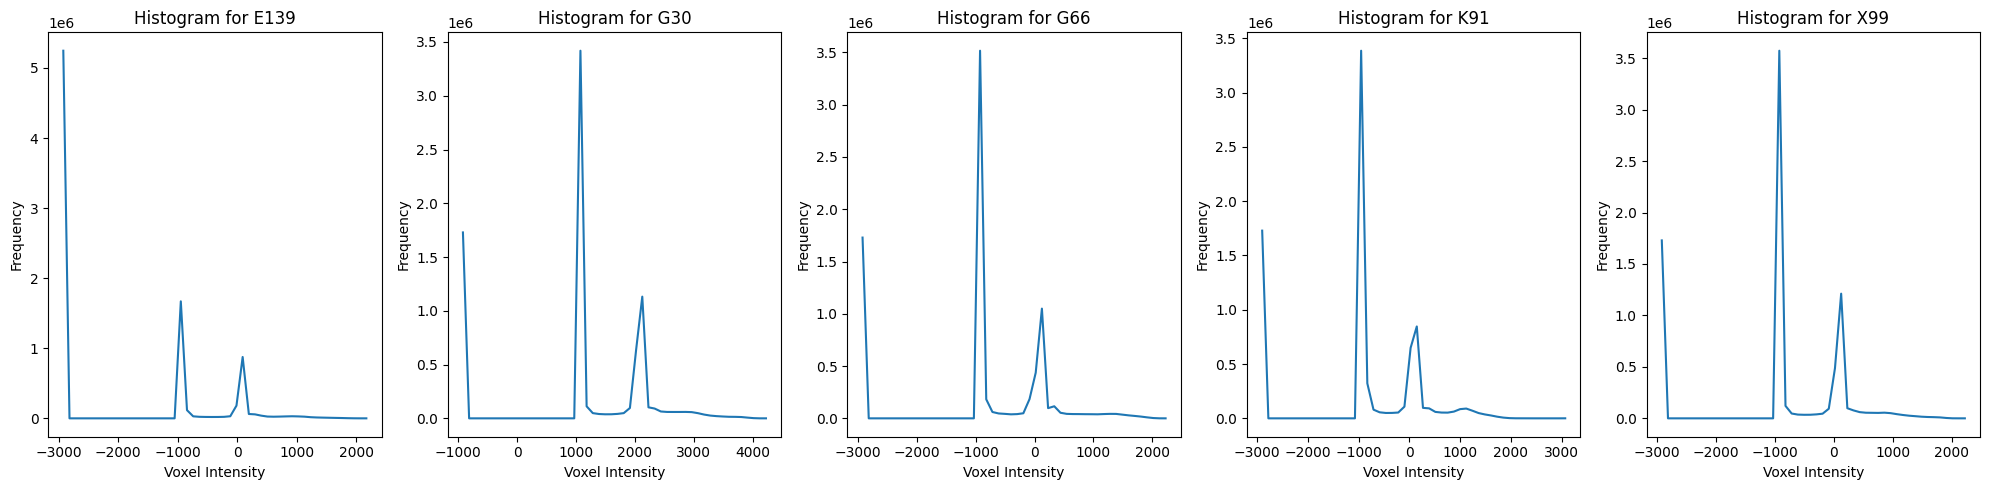

In [206]:
# 1. Compute the image histogram and identify abnormalities
abnormal_images = []
histograms = []
for i, image in enumerate(images):
    # Compute histogram
    hist, bin_edges = np.histogram(image.flatten(), bins=50)
    histograms.append((patient_names[i], hist, bin_edges))  # Store histogram with patient name
    
    # Check for abnormality in histogram (customize this condition as needed)
    if (np.max(hist) > 0.8 * len(image.flatten())) or (np.min(hist) < 0.1 * len(image.flatten())):
        abnormal_images.append(i)

# Plot all histograms side by side
plt.figure(figsize=(20, 5))
for i, (patient_name, hist, bin_edges) in enumerate(histograms):
    plt.subplot(1, len(histograms), i + 1)
    plt.title(f'Histogram for {patient_name}')
    plt.xlabel('Voxel Intensity')
    plt.ylabel('Frequency')
    plt.plot(bin_edges[1:], hist)

plt.tight_layout()
plt.show()

#### Normal Patient Histograms
**Patients:** G66, K91, and X99

Their histogram has 3 peaks:

- **First Peak:** 
  - Centered at 0 Voxel Intensity 
  - Around 1 * 10<sup>6</sup> Frequency
  
- **Second Peak:** 
  - Centered at -1000 Voxel Intensity 
  - Around 3.5 * 10<sup>6</sup> Frequency
  
- **Third Peak:** 
  - Centered at -3000 Voxel Intensity 
  - Around 1.5 * 10<sup>6</sup> Frequency


#### Abnormal Patient Histograms

##### E139:

- **First Peak:** 
  - Centered at 0 Voxel Intensity 
  - Around 1 * 10<sup>6</sup> Frequency
  
- **Second Peak:** 
  - Centered at -1000 Voxel Intensity 
  - Around 2 * 10<sup>6</sup> Frequency *abnormal from others in frequency*
  
- **Third Peak:** 
  - Centered at -3000 Voxel Intensity 
  - Around 5 * 10<sup>6</sup> Frequency *abnormal from others in frequency*


##### G30:

- **First Peak:** 
  - Centered at 2000 Voxel Intensity 
  - Around 1 * 10<sup>6</sup> Frequency *abnormal from others in voxel intensity*
  
- **Second Peak:** 
  - Centered at 1000 Voxel Intensity 
  - Around 3.5 * 10<sup>6</sup> Frequency *abnormal from others in voxel intensity*
  
- **Third Peak:** 
  - Centered at -1000 Voxel Intensity 
  - Around 1.5 * 10<sup>6</sup> Frequency *abnormal from others in voxel intensity*


### Visualize the masked images for abnormal patients

In [ ]:
# 2. Visualize the masked images for abnormal patients
for idx in abnormal_images:
    img = images[idx]
    mask = masks[idx]
    
    # Select the central slice
    central_slice_index = img.shape[0] // 2
    img_slice = img[central_slice_index]
    mask_slice = mask[central_slice_index]
    
    # Apply mask to image
    masked_image = img_slice * mask_slice
    
    # Visualization
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Original Image Slice for {patient_names[idx]}')
    plt.imshow(img_slice, cmap='gray', vmin=0, vmax=np.percentile(img_slice, 99))
    
    plt.subplot(1, 3, 2)
    plt.title(f'Mask for {patient_names[idx]}')
    plt.imshow(mask_slice, cmap='gray', vmin=0, vmax=1)
    
    plt.subplot(1, 3, 3)
    plt.title(f'Masked Image Slice for {patient_names[idx]}')
    plt.imshow(masked_image, cmap='gray', vmin=0, vmax=np.percentile(img_slice, 99))
    
    plt.tight_layout()
    plt.show()

    # Comment on the region of interest based on histogram analysis
    print(f"Analysis for Patient {patient_names[idx]}:")
    print("Masked region corresponds to unusual pixel intensities as seen in the histogram.")

Loading image from: data/imgs/E139.nii.gz
Loading mask from: data/masks/E139_mask.nii.gz
Loading image from: data/imgs/G30.nii.gz
Loading mask from: data/masks/G30_mask.nii.gz
Loading image from: data/imgs/G66.nii.gz
Loading mask from: data/masks/G66_mask.nii.gz
Loading image from: data/imgs/K91.nii.gz
Loading mask from: data/masks/K91_mask.nii.gz
Loading image from: data/imgs/X99.nii.gz
Loading mask from: data/masks/X99_mask.nii.gz


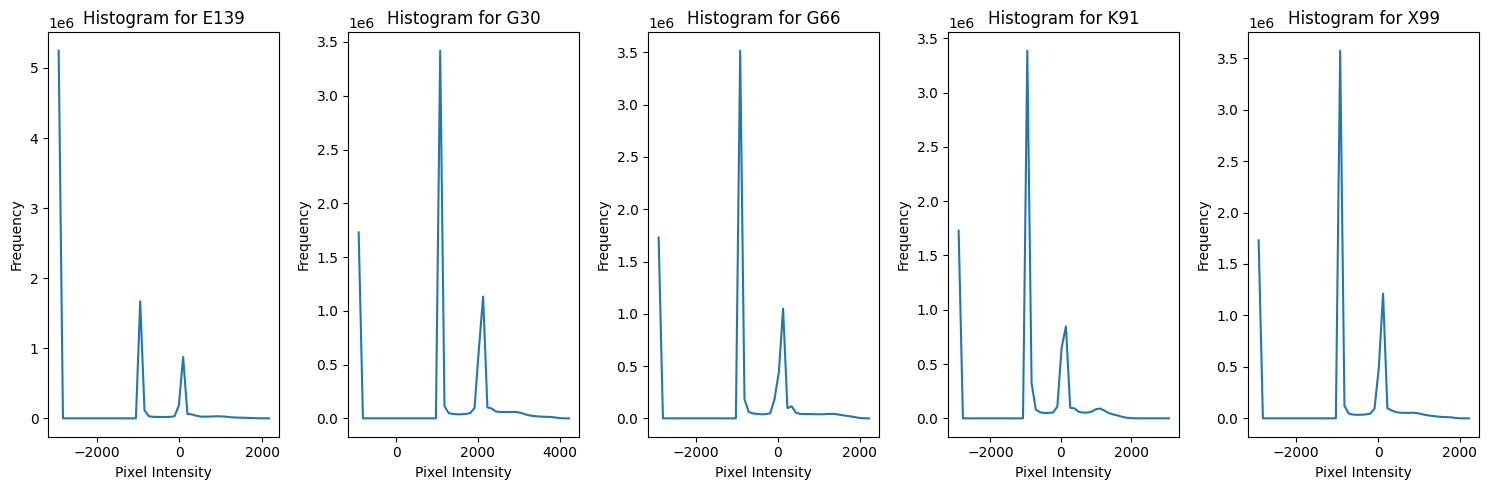

Abnormal images found at indices: [0, 1, 2, 3, 4]


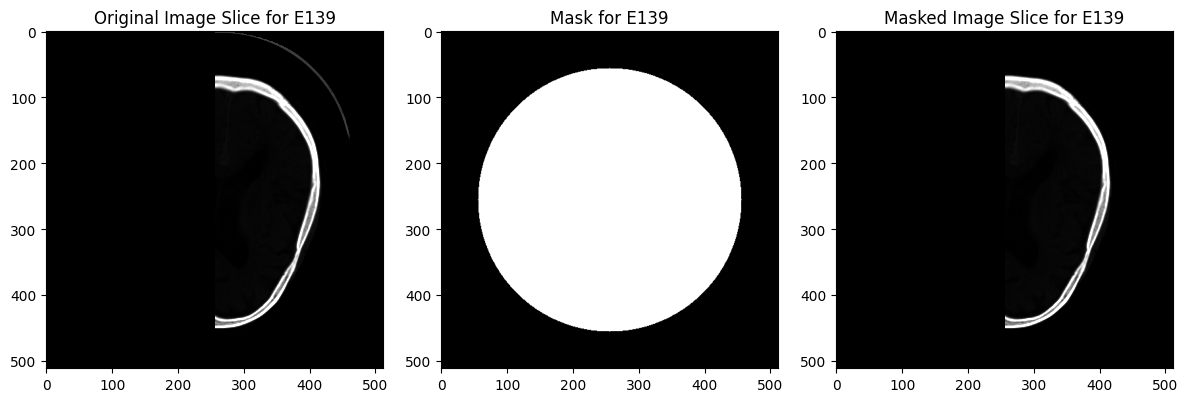

Analysis for Patient E139:
Masked region corresponds to unusual pixel intensities as seen in the histogram.


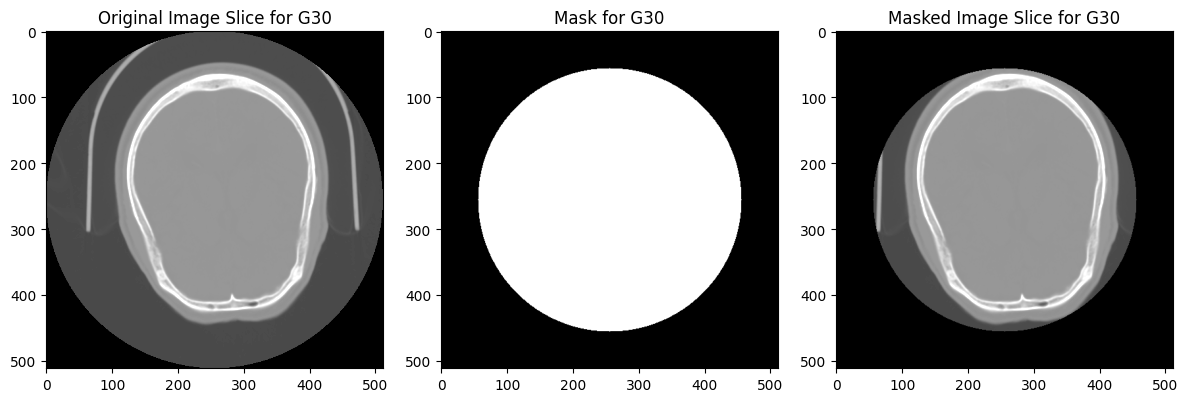

Analysis for Patient G30:
Masked region corresponds to unusual pixel intensities as seen in the histogram.


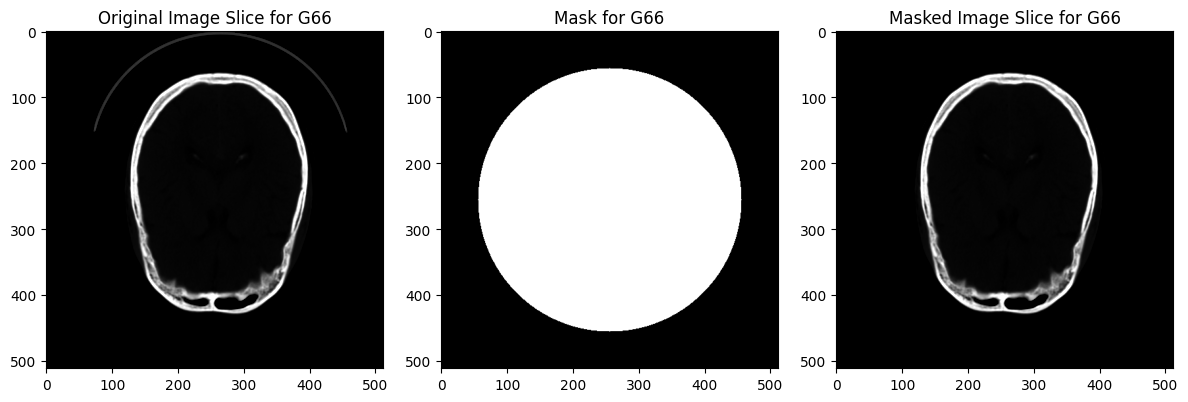

Analysis for Patient G66:
Masked region corresponds to unusual pixel intensities as seen in the histogram.


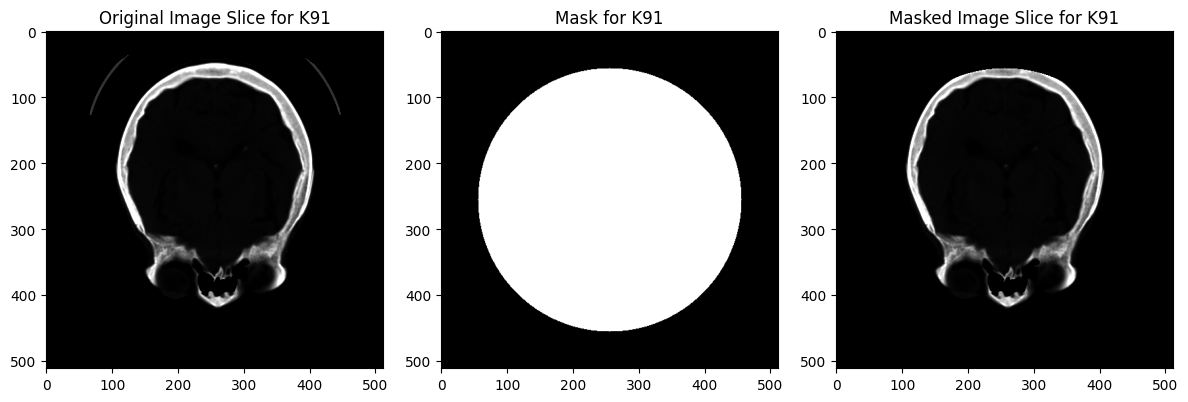

Analysis for Patient K91:
Masked region corresponds to unusual pixel intensities as seen in the histogram.


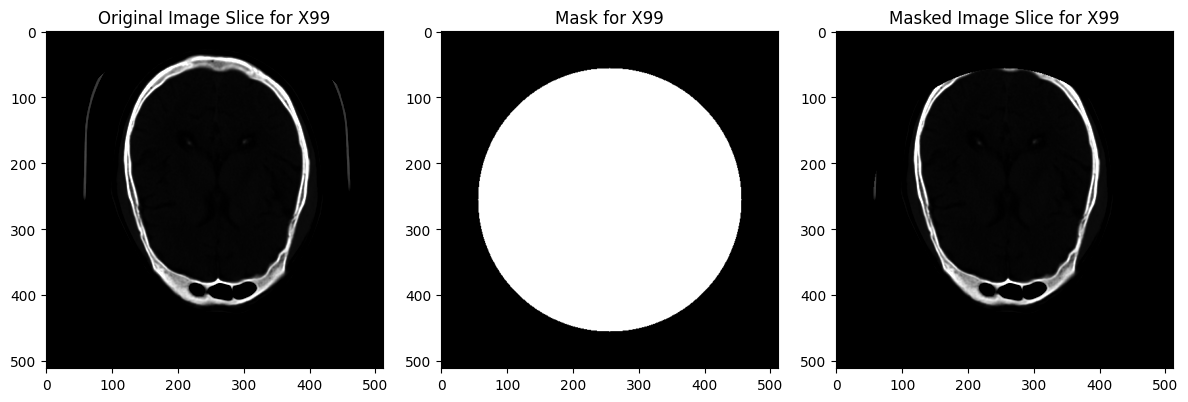

Analysis for Patient X99:
Masked region corresponds to unusual pixel intensities as seen in the histogram.


In [200]:
# Define the paths to the images and masks
img_dir = 'data/imgs'  # Path to your imgs folder
mask_dir = 'data/masks'  # Path to your masks folder

# Function to load gzipped NIfTI files
def load_gzipped_nifti_files(img_dir, mask_dir):
    images = []
    masks = []
    patient_names = []
    for img_file in sorted(os.listdir(img_dir)):
        if img_file.endswith('.nii.gz'):  # Check for gzipped NIfTI images
            img_path = os.path.join(img_dir, img_file)
            
            # Create the corresponding mask filename
            mask_file_name = img_file.replace('.nii.gz', '_mask.nii.gz')  # Mask files are gzipped too
            mask_path = os.path.join(mask_dir, mask_file_name)
            
            # Print paths for debugging
            print(f"Loading image from: {img_path}")
            print(f"Loading mask from: {mask_path}")

            # Check if mask file exists
            if not os.path.exists(mask_path):
                print(f"Warning: Mask file {mask_path} does not exist. Skipping this file.")
                continue
            
            image = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
            images.append(image)
            masks.append(mask)
            patient_names.append(img_file.split('.')[0])  # Extract patient name without the extension
    return images, masks, patient_names

# Load images and masks
images, masks, patient_names = load_gzipped_nifti_files(img_dir, mask_dir)

# 1. Compute the image histogram and identify abnormalities
abnormal_images = []
histograms = []
for i, image in enumerate(images):
    # Compute histogram
    hist, bin_edges = np.histogram(image.flatten(), bins=50)
    histograms.append((patient_names[i], hist, bin_edges))  # Store histogram with patient name
    
    # Check for abnormality in histogram (customize this condition as needed)
    if (np.max(hist) > 0.8 * len(image.flatten())) or (np.min(hist) < 0.1 * len(image.flatten())):
        abnormal_images.append(i)

# Plot all histograms side by side
plt.figure(figsize=(15, 5))
for i, (patient_name, hist, bin_edges) in enumerate(histograms):
    plt.subplot(1, len(histograms), i + 1)
    plt.title(f'Histogram for {patient_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.plot(bin_edges[1:], hist)

plt.tight_layout()
plt.show()

print("Abnormal images found at indices:", abnormal_images)

# 2. Visualize the masked images for abnormal patients
for idx in abnormal_images:
    img = images[idx]
    mask = masks[idx]
    
    # Select the central slice
    central_slice_index = img.shape[0] // 2
    img_slice = img[central_slice_index]
    mask_slice = mask[central_slice_index]
    
    # Apply mask to image
    masked_image = img_slice * mask_slice
    
    # Visualization
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Original Image Slice for {patient_names[idx]}')
    plt.imshow(img_slice, cmap='gray', vmin=0, vmax=np.percentile(img_slice, 99))
    
    plt.subplot(1, 3, 2)
    plt.title(f'Mask for {patient_names[idx]}')
    plt.imshow(mask_slice, cmap='gray', vmin=0, vmax=1)
    
    plt.subplot(1, 3, 3)
    plt.title(f'Masked Image Slice for {patient_names[idx]}')
    plt.imshow(masked_image, cmap='gray', vmin=0, vmax=np.percentile(img_slice, 99))
    
    plt.tight_layout()
    plt.show()

    # Comment on the region of interest based on histogram analysis
    print(f"Analysis for Patient {patient_names[idx]}:")
    print("Masked region corresponds to unusual pixel intensities as seen in the histogram.")


2. Visualize the masked images for abnormal patients